In [14]:
import os
import sys
import torch

# This notebook was authored with hard-coded local paths like /home/ldy/...
# In this environment we rely on:
# - EEG/Image features from HuggingFace dataset (no raw image folders required)
# - Training outputs under this repo (Generation/models, Generation/outputs)

PROJECT_ROOT = "/root/my-projects/EEG_Image_decode"
GEN_DIR = os.path.join(PROJECT_ROOT, "Generation")
DATA_DIR = "/root/autodl-tmp/weights/EEG_Image_decode"

# Make imports robust: always run from Generation/ and ensure it is on sys.path
os.chdir(GEN_DIR)
if GEN_DIR not in sys.path:
    sys.path.insert(0, GEN_DIR)

# Where your trained EEG encoder checkpoints are saved
CKPT_DIR = os.path.join(GEN_DIR, "models/contrast/ATMS/sub-08")

# Pre-extracted CLIP features (provided with the dataset)
FEATURE_TRAIN = os.path.join(DATA_DIR, "ViT-H-14_features_train.pt")
FEATURE_TEST = os.path.join(DATA_DIR, "ViT-H-14_features_test.pt")

print("GEN_DIR:", GEN_DIR)
print("CKPT_DIR:", CKPT_DIR)
print("FEATURE_TEST exists:", os.path.exists(FEATURE_TEST))
print("FEATURE_TRAIN exists:", os.path.exists(FEATURE_TRAIN))

# Raw image folders are optional. If you later download them, set these:
GT_TEST_IMAGES_DIR = os.path.join(DATA_DIR, "images_set/test_images")
GT_TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "images_set/training_images")
print("GT_TEST_IMAGES_DIR exists:", os.path.exists(GT_TEST_IMAGES_DIR))
print("GT_TRAIN_IMAGES_DIR exists:", os.path.exists(GT_TRAIN_IMAGES_DIR))

# NOTE: We intentionally do NOT scan /images_set here to avoid FileNotFoundError when images are not present.
texts, images = [], []

# --------------------
# Put ALL outputs/caches on a large filesystem (avoid filling the 30G system disk)
# --------------------
BIG_OUTPUT_DIR = "/root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8"
os.makedirs(BIG_OUTPUT_DIR, exist_ok=True)
print("BIG_OUTPUT_DIR:", BIG_OUTPUT_DIR)

# Redirect common ML caches to the big disk (effective for downloads done after this cell runs)
os.environ.setdefault("XDG_CACHE_HOME", os.path.join(BIG_OUTPUT_DIR, ".cache"))
os.environ.setdefault("HF_HOME", os.path.join(BIG_OUTPUT_DIR, ".cache", "huggingface"))
os.environ.setdefault("TORCH_HOME", os.path.join(BIG_OUTPUT_DIR, ".cache", "torch"))


GEN_DIR: /root/my-projects/EEG_Image_decode/Generation
CKPT_DIR: /root/my-projects/EEG_Image_decode/Generation/models/contrast/ATMS/sub-08
FEATURE_TEST exists: True
FEATURE_TRAIN exists: True
GT_TEST_IMAGES_DIR exists: True
GT_TRAIN_IMAGES_DIR exists: True
BIG_OUTPUT_DIR: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8


'/root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/.cache/torch'

In [15]:
texts

[]

In [16]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

# Keep wandb optional/offline. Do not hardcode API keys in notebooks.
os.environ.setdefault("WANDB_MODE", "offline")

from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset

from einops.layers.torch import Rearrange, Reduce

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
import sys

# In notebooks __file__ is not defined; use the project root from Cell 0.
sys.path.append(PROJECT_ROOT)

from models.util import wandb_logger
from braindecode.models import EEGNetv4, ATCNet, EEGConformer, EEGITNet, ShallowFBCSPNet
import csv
from torch import Tensor
import itertools
import math
import re
from models.subject_layers.Transformer_EncDec import Encoder, EncoderLayer
from models.subject_layers.SelfAttention_Family import FullAttention, AttentionLayer
from models.subject_layers.Embed import DataEmbedding
import numpy as np
from models.loss import ClipLoss
import argparse
from torch import nn
from torch.optim import AdamW


class Config:
    def __init__(self):
        self.task_name = 'classification'  # Example task name
        self.seq_len = 250                 # Sequence length
        self.pred_len = 250                # Prediction length
        self.output_attention = False      # Whether to output attention weights
        self.d_model = 250                 # Model dimension
        self.embed = 'timeF'               # Time encoding method
        self.freq = 'h'                    # Time frequency
        self.dropout = 0.25                # Dropout rate
        self.factor = 1                    # Attention scaling factor
        self.n_heads = 4                   # Number of attention heads
        self.e_layers = 1                  # Number of encoder layers
        self.d_ff = 256                    # Dimension of the feedforward network
        self.activation = 'gelu'           # Activation function
        self.enc_in = 63                   # Encoder input dimension (example value)

class iTransformer(nn.Module):
    def __init__(self, configs, joint_train=False,  num_subjects=10):
        super(iTransformer, self).__init__()
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        # Embedding
        self.enc_embedding = DataEmbedding(configs.seq_len, configs.d_model, configs.embed, configs.freq, configs.dropout, joint_train=False, num_subjects=num_subjects)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=configs.output_attention),
                        configs.d_model, configs.n_heads
                    ),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )

    def forward(self, x_enc, x_mark_enc, subject_ids=None):
        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc, subject_ids)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        enc_out = enc_out[:, :63, :]      
        # print("enc_out", enc_out.shape)
        return enc_out

class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # Revised from ShallowNet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), stride=(1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), stride=(1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x

class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )

class ATMS(nn.Module):    
    def __init__(self, num_channels=63, sequence_length=25, num_subjects=1, num_features=64, num_latents=1024, num_blocks=1):
        super(ATMS, self).__init__()
        default_config = Config()
        self.encoder = iTransformer(default_config)   
        self.subject_wise_linear = nn.ModuleList([nn.Linear(default_config.d_model, sequence_length) for _ in range(num_subjects)])
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()       
         
    def forward(self, x, subject_ids):
        x = self.encoder(x, None, subject_ids)
        # print(f'After attention shape: {x.shape}')
        # print("x", x.shape)
        # x = self.subject_wise_linear[0](x)
        # print(f'After subject-specific linear transformation shape: {x.shape}')
        eeg_embedding = self.enc_eeg(x)
        
        out = self.proj_eeg(eeg_embedding)
        return out  


def extract_id_from_string(s):
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group())
    return None



    

def get_eegfeatures(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0

    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features    
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            
            batch_size = eeg_data.size(0)  # Assume the first element is the data tensor
            subject_id = extract_id_from_string(sub)
            # eeg_data = eeg_data.permute(0, 2, 1)
            subject_ids = torch.full((batch_size,), subject_id, dtype=torch.long).to(device)
            # if not config.insubject:
            #     subject_ids = torch.full((batch_size,), -1, dtype=torch.long).to(device)          
            eeg_features = eeg_model(eeg_data, subject_ids)
            features_list.append(eeg_features.detach().cpu())

        
            logit_scale = eeg_model.logit_scale 
                   
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):

                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]
                

                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                # logits_single = (logits_text + logits_img) / 2.0
                logits_single = logits_img
                # print("logits_single", logits_single.shape)

                # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1        
                total += 1

        if save_features:
            if len(features_list) == 0:
                raise RuntimeError(
                    "No EEG features were collected. Check dataloader length and make sure features_list.append(...) is executed."
                )
            features_tensor = torch.cat(features_list, dim=0)
            print("features_tensor", features_tensor.shape)
            out_path = os.path.join(BIG_OUTPUT_DIR, f"ATM_S_eeg_features_{sub}.pt")
            torch.save(features_tensor.cpu(), out_path)
            print("Saved EEG features to:", out_path)
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()

from IPython.display import Image, display
import glob

# Use the same paths as defined in Cell 0
config = {
    "data_path": os.path.join(DATA_DIR, "Preprocessed_data_250Hz"),
    "project": "train_pos_img_text_rep",
    "entity": "sustech_rethinkingbci",
    "name": "lr=3e-4_img_pos_pro_eeg",
    "lr": 3e-4,
    "epochs": 50,
    "batch_size": 1024,
    "logger": True,
    "encoder_type": "ATMS",
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = config["data_path"]

# Load pre-extracted CLIP image embeddings (no raw image folders required)
emb_img_test = torch.load(FEATURE_TEST, map_location="cpu")["img_features"]
emb_img_train = torch.load(FEATURE_TRAIN, map_location="cpu")["img_features"]

# Load the latest trained EEG encoder checkpoint (sub-08)
# NOTE: naive lexicographic sorting may pick 5.pth as "latest"; instead pick by epoch number.
ckpt_candidates = glob.glob(os.path.join(CKPT_DIR, "**", "*.pth"), recursive=True)
assert len(ckpt_candidates) > 0, f"No .pth checkpoints found under {CKPT_DIR}"

def _epoch_from_path(p: str) -> int:
    # filename is like .../5.pth, 10.pth, 40.pth
    base = os.path.basename(p)
    try:
        return int(os.path.splitext(base)[0])
    except Exception:
        return -1

ckpt_path = sorted(ckpt_candidates, key=_epoch_from_path)[-1]
print("Using EEG encoder ckpt:", ckpt_path)

# IMPORTANT: in notebooks, avoid redefining model classes.
# Use the exact ATMS implementation from the training script to match checkpoints.
from ATMS_reconstruction import ATMS as ATMS_TRAIN

eeg_model = ATMS_TRAIN(63, 250, num_subjects=2)
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

eeg_model.load_state_dict(torch.load(ckpt_path, map_location=device), strict=True)
eeg_model = eeg_model.to(device)
sub = "sub-08"

# Extract EEG embeddings for test split

test_dataset = EEGDataset(data_path, subjects=[sub], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features

test_loss, test_accuracy, labels, eeg_features_test = get_eegfeatures(
    sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all, k=200
)
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Using EEG encoder ckpt: /root/my-projects/EEG_Image_decode/Generation/models/contrast/ATMS/sub-08/01-20_18-35/40.pth
number of parameters: 3202413
self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 0, image length: 0
features_tensor torch.Size([200, 1024])
Saved EEG features to: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/ATM_S_eeg_features_sub-08.pt
 - Test Loss: 2.3282, Test Accuracy: 0.3750


In [17]:
#####################################################################################
train_dataset = EEGDataset(data_path, subjects= [sub], train=True)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = train_dataset.text_features
img_features_test_all = train_dataset.img_features

train_loss, train_accuracy, labels, eeg_features_train = get_eegfeatures(sub, eeg_model, train_loader, device, text_features_test_all, img_features_test_all,k=200)
print(f" - Test Loss: {train_loss:.4f}, Test Accuracy: {train_accuracy:.4f}")
#####################################################################################

self.subjects ['sub-08']
exclude_subject None
data_tensor torch.Size([66160, 63, 250])
Data tensor shape: torch.Size([66160, 63, 250]), label tensor shape: torch.Size([66160]), text length: 0, image length: 0
features_tensor torch.Size([66160, 1024])
Saved EEG features to: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/ATM_S_eeg_features_sub-08.pt
 - Test Loss: 3.0674, Test Accuracy: 0.0050


In [18]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open_clip
from matplotlib.font_manager import FontProperties

import sys
from diffusion_prior import *
from custom_pipeline import *
# os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)

# Use embeddings computed above (avoid hardcoded /home/ldy paths)
emb_eeg = eeg_features_train
emb_eeg_test = eeg_features_test

In [20]:
emb_eeg.shape, emb_eeg_test.shape

(torch.Size([66160, 1024]), torch.Size([200, 1024]))

In [21]:
eeg_features_train

tensor([[ 0.0099,  0.0115, -0.0674,  ...,  0.0317, -0.1903,  0.0373],
        [-0.0091,  0.1900,  0.1403,  ...,  0.0502, -0.1093, -0.1155],
        [-0.0540, -0.0569, -0.0679,  ...,  0.0456, -0.1599, -0.1122],
        ...,
        [ 0.0846, -0.0921,  0.1796,  ..., -0.0867, -0.0533,  0.2075],
        [-0.0004,  0.0611,  0.1666,  ..., -0.0968,  0.0288,  0.0756],
        [ 0.0689, -0.0689,  0.0081,  ..., -0.0129, -0.0189,  0.0524]])

In [22]:
dataset = EmbeddingDataset(
    c_embeddings=eeg_features_train, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
dl = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.train(dl, num_epochs=150, learning_rate=1e-3) # to 0.142 
# pipe.diffusion_prior.load_state_dict(torch.load(f'./fintune_ckpts/{config['encoder_type']}/{sub}/{model_name}.pt', map_location=device))

9675648
epoch: 0, loss: 1.1293863938404964
epoch: 1, loss: 0.8877951988807091
epoch: 2, loss: 0.6522992913539593
epoch: 3, loss: 0.48376718851236195
epoch: 4, loss: 0.3618350854286781
epoch: 5, loss: 0.2725532909998527
epoch: 6, loss: 0.215103217959404
epoch: 7, loss: 0.181322350868812
epoch: 8, loss: 0.15814917546052198
epoch: 9, loss: 0.13976977054889386
epoch: 10, loss: 0.12394821494817734
epoch: 11, loss: 0.1095162693124551
epoch: 12, loss: 0.09683019392765485
epoch: 13, loss: 0.08593009286201918
epoch: 14, loss: 0.07665263311221049
epoch: 15, loss: 0.06894176636750882
epoch: 16, loss: 0.061926416995433664
epoch: 17, loss: 0.056290297783338106
epoch: 18, loss: 0.0506204828619957
epoch: 19, loss: 0.0468095923272463
epoch: 20, loss: 0.04317730143666267
epoch: 21, loss: 0.04043067911496529
epoch: 22, loss: 0.037549331325751084
epoch: 23, loss: 0.035057633943282644
epoch: 24, loss: 0.033501352971562974
epoch: 25, loss: 0.03227758290102849
epoch: 26, loss: 0.03009622598496767
epoch: 27,

In [ ]:

# pipe.diffusion_prior.load_state_dict(torch.load(f'./fintune_ckpts/{config['data_path']}/{sub}/{model_name}.pt', map_location=device))

# Save finetuned prior + generated images to BIG_OUTPUT_DIR (big disk)
prior_ckpt_path = os.path.join(
    BIG_OUTPUT_DIR,
    "fintune_ckpts",
    config["encoder_type"],
    sub,
    f"{model_name}.pt",
)
os.makedirs(os.path.dirname(prior_ckpt_path), exist_ok=True)
torch.save(pipe.diffusion_prior.state_dict(), prior_ckpt_path)
print("Saved prior ckpt to:", prior_ckpt_path)

from PIL import Image
import os

# Assuming generator.generate returns a PIL Image
# Put SDXL + IP-Adapter on GPU1 (GPU0 is typically busy with EEG/prior steps)
GEN_DEVICE = "cuda:1" if torch.cuda.device_count() > 1 else str(device)
print("Generator device:", GEN_DEVICE)

# Backward-compatible: older Generator4Embeds may not support cpu_offload kwarg
try:
    generator = Generator4Embeds(num_inference_steps=4, device=GEN_DEVICE, cpu_offload=False)
except TypeError:
    generator = Generator4Embeds(num_inference_steps=4, device=GEN_DEVICE)

gen_root = os.path.join(BIG_OUTPUT_DIR, "generated_imgs", sub)
for k in range(200):
    eeg_embeds = emb_eeg_test[k:k+1]
    h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
    class_dir = texts[k] if (isinstance(texts, (list, tuple)) and len(texts) > k) else f"class_{k:04d}"
    for j in range(10):
        image = generator.generate(h.to(dtype=torch.float16))
        path = os.path.join(gen_root, class_dir, f"{j}.png")
        os.makedirs(os.path.dirname(path), exist_ok=True)
        image.save(path)
        # keep logs light
        if j == 0:
            print("Saved:", path)

Saved prior ckpt to: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/fintune_ckpts/ATMS/sub-08/diffusion_prior.pt


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]
/root/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
50it [00:00, 188.53it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/root/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/models/embeddings.py:1540: FutureWarning: You have passed a tensor as `image_embeds`.This is deprecated and will be removed in a future release. Please make sure to update your script to pass `image_embeds` as a list of tensors to suppress this warning.
  deprecate("image_embeds not a list", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0000/0.png


100%|██████████| 4/4 [00:00<00:00, 13.81it/s]
50it [00:00, 252.59it/s]
100%|██████████| 4/4 [00:00<00:00, 13.61it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0001/0.png


100%|██████████| 4/4 [00:00<00:00,  9.67it/s]
50it [00:00, 153.20it/s]
100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0002/0.png


100%|██████████| 4/4 [00:00<00:00,  8.57it/s]
50it [00:00, 264.61it/s]
100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0003/0.png


100%|██████████| 4/4 [00:00<00:00, 13.09it/s]
50it [00:00, 258.77it/s]
100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0004/0.png


100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
50it [00:00, 263.43it/s]
100%|██████████| 4/4 [00:00<00:00, 13.53it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0005/0.png


100%|██████████| 4/4 [00:00<00:00, 13.59it/s]
50it [00:00, 250.63it/s]
100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0006/0.png


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]
50it [00:00, 161.98it/s]
100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0007/0.png


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]
50it [00:00, 159.05it/s]
100%|██████████| 4/4 [00:00<00:00,  8.52it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0008/0.png


100%|██████████| 4/4 [00:00<00:00, 13.38it/s]
50it [00:00, 256.22it/s]
100%|██████████| 4/4 [00:00<00:00, 13.21it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0009/0.png


100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
50it [00:00, 163.65it/s]
100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0010/0.png


100%|██████████| 4/4 [00:00<00:00, 13.36it/s]
50it [00:00, 251.98it/s]
100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0011/0.png


100%|██████████| 4/4 [00:00<00:00, 13.40it/s]
50it [00:00, 254.54it/s]
100%|██████████| 4/4 [00:00<00:00, 13.39it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0012/0.png


100%|██████████| 4/4 [00:00<00:00,  8.62it/s]
50it [00:00, 161.36it/s]
100%|██████████| 4/4 [00:00<00:00,  8.62it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0013/0.png


100%|██████████| 4/4 [00:00<00:00, 13.57it/s]
50it [00:00, 187.25it/s]
100%|██████████| 4/4 [00:00<00:00,  9.86it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0014/0.png


100%|██████████| 4/4 [00:00<00:00, 13.31it/s]
50it [00:00, 263.16it/s]
100%|██████████| 4/4 [00:00<00:00, 13.56it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0015/0.png


100%|██████████| 4/4 [00:00<00:00, 13.85it/s]
50it [00:00, 260.69it/s]
100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0016/0.png


100%|██████████| 4/4 [00:00<00:00,  8.63it/s]
50it [00:00, 161.62it/s]
100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0017/0.png


100%|██████████| 4/4 [00:00<00:00, 13.65it/s]
50it [00:00, 260.82it/s]
100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0018/0.png


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
50it [00:00, 255.84it/s]
100%|██████████| 4/4 [00:00<00:00, 13.48it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0019/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 259.85it/s]
100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0020/0.png


100%|██████████| 4/4 [00:00<00:00, 13.68it/s]
50it [00:00, 264.20it/s]
100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0021/0.png


100%|██████████| 4/4 [00:00<00:00, 13.72it/s]
50it [00:00, 253.14it/s]
100%|██████████| 4/4 [00:00<00:00, 13.56it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0022/0.png


100%|██████████| 4/4 [00:00<00:00, 13.60it/s]
50it [00:00, 263.21it/s]
100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0023/0.png


100%|██████████| 4/4 [00:00<00:00, 13.44it/s]
50it [00:00, 263.77it/s]
100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0024/0.png


100%|██████████| 4/4 [00:00<00:00, 10.67it/s]
50it [00:00, 214.95it/s]
100%|██████████| 4/4 [00:00<00:00, 12.57it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0025/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 260.39it/s]
100%|██████████| 4/4 [00:00<00:00, 13.56it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0026/0.png


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
50it [00:00, 260.38it/s]
100%|██████████| 4/4 [00:00<00:00, 13.20it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0027/0.png


100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
50it [00:00, 263.52it/s]
100%|██████████| 4/4 [00:00<00:00, 13.63it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0028/0.png


100%|██████████| 4/4 [00:00<00:00, 13.42it/s]
50it [00:00, 254.72it/s]
100%|██████████| 4/4 [00:00<00:00, 13.38it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0029/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 258.13it/s]
100%|██████████| 4/4 [00:00<00:00, 13.79it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0030/0.png


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
50it [00:00, 260.40it/s]
100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0031/0.png


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
50it [00:00, 261.33it/s]
100%|██████████| 4/4 [00:00<00:00, 13.70it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0032/0.png


100%|██████████| 4/4 [00:00<00:00, 13.80it/s]
50it [00:00, 262.12it/s]
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0033/0.png


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]
50it [00:00, 262.16it/s]
100%|██████████| 4/4 [00:00<00:00, 13.69it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0034/0.png


100%|██████████| 4/4 [00:00<00:00, 13.79it/s]
50it [00:00, 261.14it/s]
100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0035/0.png


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]
50it [00:00, 261.44it/s]
100%|██████████| 4/4 [00:00<00:00, 13.38it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0036/0.png


100%|██████████| 4/4 [00:00<00:00, 13.57it/s]
50it [00:00, 260.68it/s]
100%|██████████| 4/4 [00:00<00:00, 13.71it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0037/0.png


100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
50it [00:00, 261.73it/s]
100%|██████████| 4/4 [00:00<00:00, 13.62it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0038/0.png


100%|██████████| 4/4 [00:00<00:00, 13.69it/s]
50it [00:00, 266.66it/s]
100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0039/0.png


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]
50it [00:00, 261.72it/s]
100%|██████████| 4/4 [00:00<00:00, 13.61it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0040/0.png


100%|██████████| 4/4 [00:00<00:00, 13.87it/s]
50it [00:00, 261.90it/s]
100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0041/0.png


100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
50it [00:00, 259.82it/s]
100%|██████████| 4/4 [00:00<00:00, 13.68it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0042/0.png


100%|██████████| 4/4 [00:00<00:00, 13.87it/s]
50it [00:00, 265.41it/s]
100%|██████████| 4/4 [00:00<00:00, 11.34it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0043/0.png


100%|██████████| 4/4 [00:00<00:00,  8.56it/s]
50it [00:00, 194.38it/s]
100%|██████████| 4/4 [00:00<00:00, 13.54it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0044/0.png


100%|██████████| 4/4 [00:00<00:00, 13.38it/s]
50it [00:00, 97.91it/s] 
100%|██████████| 4/4 [00:00<00:00, 13.40it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0045/0.png


100%|██████████| 4/4 [00:00<00:00, 13.49it/s]
50it [00:00, 259.19it/s]
100%|██████████| 4/4 [00:00<00:00, 13.32it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0046/0.png


100%|██████████| 4/4 [00:00<00:00, 13.52it/s]
50it [00:00, 259.20it/s]
100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0047/0.png


100%|██████████| 4/4 [00:00<00:00, 13.34it/s]
50it [00:00, 255.62it/s]
100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0048/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 261.21it/s]
100%|██████████| 4/4 [00:00<00:00, 13.41it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0049/0.png


100%|██████████| 4/4 [00:00<00:00, 13.51it/s]
50it [00:00, 258.64it/s]
100%|██████████| 4/4 [00:00<00:00, 13.60it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0050/0.png


100%|██████████| 4/4 [00:00<00:00, 13.92it/s]
50it [00:00, 260.55it/s]
100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0051/0.png


100%|██████████| 4/4 [00:00<00:00, 13.91it/s]
50it [00:00, 256.99it/s]
100%|██████████| 4/4 [00:00<00:00, 13.87it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0052/0.png


100%|██████████| 4/4 [00:00<00:00, 13.84it/s]
50it [00:00, 257.07it/s]
100%|██████████| 4/4 [00:00<00:00, 13.62it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0053/0.png


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]
50it [00:00, 265.10it/s]
100%|██████████| 4/4 [00:00<00:00, 13.71it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0054/0.png


100%|██████████| 4/4 [00:00<00:00, 13.69it/s]
50it [00:00, 260.64it/s]
100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0055/0.png


100%|██████████| 4/4 [00:00<00:00, 13.87it/s]
50it [00:00, 259.53it/s]
100%|██████████| 4/4 [00:00<00:00, 13.61it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0056/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 264.14it/s]
100%|██████████| 4/4 [00:00<00:00, 13.72it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0057/0.png


100%|██████████| 4/4 [00:00<00:00, 13.81it/s]
50it [00:00, 259.52it/s]
100%|██████████| 4/4 [00:00<00:00, 13.58it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0058/0.png


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]
50it [00:00, 264.38it/s]
100%|██████████| 4/4 [00:00<00:00, 13.50it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0059/0.png


100%|██████████| 4/4 [00:00<00:00, 13.89it/s]
50it [00:00, 262.63it/s]
100%|██████████| 4/4 [00:00<00:00, 13.85it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0060/0.png


100%|██████████| 4/4 [00:00<00:00,  8.44it/s]
50it [00:00, 160.57it/s]
100%|██████████| 4/4 [00:00<00:00,  9.29it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0061/0.png


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
50it [00:00, 258.99it/s]
100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0062/0.png


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
50it [00:00, 259.22it/s]
100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0063/0.png


100%|██████████| 4/4 [00:00<00:00, 13.49it/s]
50it [00:00, 257.37it/s]
100%|██████████| 4/4 [00:00<00:00, 13.29it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0064/0.png


100%|██████████| 4/4 [00:00<00:00,  7.95it/s]
50it [00:00, 157.07it/s]
100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0065/0.png


100%|██████████| 4/4 [00:00<00:00, 13.84it/s]
50it [00:00, 263.52it/s]
100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0066/0.png


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]
50it [00:00, 262.48it/s]
100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0067/0.png


100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
50it [00:00, 262.10it/s]
100%|██████████| 4/4 [00:00<00:00, 13.81it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0068/0.png


100%|██████████| 4/4 [00:00<00:00, 13.87it/s]
50it [00:00, 266.69it/s]
100%|██████████| 4/4 [00:00<00:00, 13.90it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0069/0.png


100%|██████████| 4/4 [00:00<00:00, 13.66it/s]
50it [00:00, 262.02it/s]
100%|██████████| 4/4 [00:00<00:00, 13.80it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0070/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 262.48it/s]
100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0071/0.png


100%|██████████| 4/4 [00:00<00:00, 13.60it/s]
50it [00:00, 253.89it/s]
100%|██████████| 4/4 [00:00<00:00, 13.54it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0072/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 257.32it/s]
100%|██████████| 4/4 [00:00<00:00, 13.50it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0073/0.png


100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
50it [00:00, 242.14it/s]
100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0074/0.png


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
50it [00:00, 260.57it/s]
100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0075/0.png


100%|██████████| 4/4 [00:00<00:00, 13.59it/s]
50it [00:00, 260.38it/s]
100%|██████████| 4/4 [00:00<00:00, 13.65it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0076/0.png


100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
50it [00:00, 256.91it/s]
100%|██████████| 4/4 [00:00<00:00, 13.68it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0077/0.png


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
50it [00:00, 257.32it/s]
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0078/0.png


100%|██████████| 4/4 [00:00<00:00,  8.57it/s]
50it [00:00, 160.38it/s]
100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0079/0.png


100%|██████████| 4/4 [00:00<00:00, 13.76it/s]
50it [00:00, 262.98it/s]
100%|██████████| 4/4 [00:00<00:00, 13.63it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0080/0.png


100%|██████████| 4/4 [00:00<00:00,  8.62it/s]
50it [00:00, 159.36it/s]
100%|██████████| 4/4 [00:00<00:00,  8.58it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0081/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 257.30it/s]
100%|██████████| 4/4 [00:00<00:00, 13.62it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0082/0.png


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
50it [00:00, 260.46it/s]
100%|██████████| 4/4 [00:00<00:00, 13.72it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0083/0.png


100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
50it [00:00, 259.22it/s]
100%|██████████| 4/4 [00:00<00:00, 13.64it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0084/0.png


100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
50it [00:00, 264.31it/s]
100%|██████████| 4/4 [00:00<00:00, 13.60it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0085/0.png


100%|██████████| 4/4 [00:00<00:00, 11.00it/s]
50it [00:00, 260.64it/s]
100%|██████████| 4/4 [00:00<00:00, 13.79it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0086/0.png


100%|██████████| 4/4 [00:00<00:00, 13.71it/s]
50it [00:00, 266.12it/s]
100%|██████████| 4/4 [00:00<00:00, 13.65it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0087/0.png


100%|██████████| 4/4 [00:00<00:00, 13.68it/s]
50it [00:00, 262.10it/s]
100%|██████████| 4/4 [00:00<00:00, 13.82it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0088/0.png


100%|██████████| 4/4 [00:00<00:00, 13.82it/s]
50it [00:00, 267.42it/s]
100%|██████████| 4/4 [00:00<00:00, 13.80it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0089/0.png


100%|██████████| 4/4 [00:00<00:00, 13.66it/s]
50it [00:00, 255.21it/s]
100%|██████████| 4/4 [00:00<00:00, 13.62it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0090/0.png


100%|██████████| 4/4 [00:00<00:00, 13.80it/s]
50it [00:00, 258.15it/s]
100%|██████████| 4/4 [00:00<00:00, 13.84it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0091/0.png


100%|██████████| 4/4 [00:00<00:00, 13.49it/s]
50it [00:00, 254.47it/s]
100%|██████████| 4/4 [00:00<00:00, 13.30it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0092/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 107.92it/s]
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0093/0.png


100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
50it [00:00, 256.35it/s]
100%|██████████| 4/4 [00:00<00:00, 13.60it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0094/0.png


100%|██████████| 4/4 [00:00<00:00, 13.58it/s]
50it [00:00, 263.44it/s]
100%|██████████| 4/4 [00:00<00:00, 13.74it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0095/0.png


100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
50it [00:00, 258.83it/s]
100%|██████████| 4/4 [00:00<00:00, 13.74it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0096/0.png


100%|██████████| 4/4 [00:00<00:00, 13.84it/s]
50it [00:00, 258.74it/s]
100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0097/0.png


100%|██████████| 4/4 [00:00<00:00, 13.79it/s]
50it [00:00, 257.72it/s]
100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0098/0.png


100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
50it [00:00, 192.91it/s]
100%|██████████| 4/4 [00:00<00:00,  8.22it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0099/0.png


100%|██████████| 4/4 [00:00<00:00, 13.65it/s]
50it [00:00, 259.92it/s]
100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0100/0.png


100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
50it [00:00, 252.74it/s]
100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0101/0.png


100%|██████████| 4/4 [00:00<00:00, 13.63it/s]
50it [00:00, 259.41it/s]
100%|██████████| 4/4 [00:00<00:00, 13.56it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0102/0.png


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]
50it [00:00, 262.08it/s]
100%|██████████| 4/4 [00:00<00:00, 13.73it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0103/0.png


100%|██████████| 4/4 [00:00<00:00, 13.40it/s]
50it [00:00, 260.40it/s]
100%|██████████| 4/4 [00:00<00:00, 13.56it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0104/0.png


100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
50it [00:00, 258.36it/s]
100%|██████████| 4/4 [00:00<00:00, 13.48it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0105/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 262.73it/s]
100%|██████████| 4/4 [00:00<00:00, 13.51it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0106/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 255.84it/s]
100%|██████████| 4/4 [00:00<00:00, 13.41it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0107/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 262.43it/s]
100%|██████████| 4/4 [00:00<00:00, 13.48it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0108/0.png


100%|██████████| 4/4 [00:00<00:00,  8.57it/s]
50it [00:00, 160.33it/s]
100%|██████████| 4/4 [00:00<00:00,  8.58it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0109/0.png


100%|██████████| 4/4 [00:00<00:00, 13.55it/s]
50it [00:00, 249.79it/s]
100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0110/0.png


100%|██████████| 4/4 [00:00<00:00, 11.19it/s]
50it [00:00, 264.27it/s]
100%|██████████| 4/4 [00:00<00:00, 13.51it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0111/0.png


100%|██████████| 4/4 [00:00<00:00, 13.33it/s]
50it [00:00, 264.22it/s]
100%|██████████| 4/4 [00:00<00:00, 13.40it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0112/0.png


100%|██████████| 4/4 [00:00<00:00, 13.81it/s]
50it [00:00, 258.57it/s]
100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0113/0.png


100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
50it [00:00, 261.57it/s]
100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0114/0.png


100%|██████████| 4/4 [00:00<00:00, 13.79it/s]
50it [00:00, 160.16it/s]
100%|██████████| 4/4 [00:00<00:00,  8.68it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0115/0.png


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]
50it [00:00, 261.48it/s]
100%|██████████| 4/4 [00:00<00:00, 13.79it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0116/0.png


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]
50it [00:00, 263.24it/s]
100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0117/0.png


100%|██████████| 4/4 [00:00<00:00,  8.51it/s]
50it [00:00, 152.78it/s]
100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0118/0.png


100%|██████████| 4/4 [00:00<00:00,  8.66it/s]
50it [00:00, 154.12it/s]
100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0119/0.png


100%|██████████| 4/4 [00:00<00:00,  8.47it/s]
50it [00:00, 153.52it/s]
100%|██████████| 4/4 [00:00<00:00,  8.65it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0120/0.png


100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
50it [00:00, 258.21it/s]
100%|██████████| 4/4 [00:00<00:00, 13.35it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0121/0.png


100%|██████████| 4/4 [00:00<00:00,  8.47it/s]
50it [00:00, 157.77it/s]
100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0122/0.png


100%|██████████| 4/4 [00:00<00:00, 13.28it/s]
50it [00:00, 257.49it/s]
100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0123/0.png


100%|██████████| 4/4 [00:00<00:00, 13.40it/s]
50it [00:00, 254.78it/s]
100%|██████████| 4/4 [00:00<00:00, 13.32it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0124/0.png


100%|██████████| 4/4 [00:00<00:00, 13.25it/s]
50it [00:00, 239.10it/s]
100%|██████████| 4/4 [00:00<00:00, 13.25it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0125/0.png


100%|██████████| 4/4 [00:00<00:00, 13.36it/s]
50it [00:00, 253.73it/s]
100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0126/0.png


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]
50it [00:00, 247.07it/s]
100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0127/0.png


100%|██████████| 4/4 [00:00<00:00,  8.60it/s]
50it [00:00, 258.49it/s]
100%|██████████| 4/4 [00:00<00:00, 13.60it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0128/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 262.33it/s]
100%|██████████| 4/4 [00:00<00:00, 13.88it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0129/0.png


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]
50it [00:00, 262.74it/s]
100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0130/0.png


100%|██████████| 4/4 [00:00<00:00, 13.81it/s]
50it [00:00, 258.51it/s]
100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0131/0.png


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]
50it [00:00, 263.95it/s]
100%|██████████| 4/4 [00:00<00:00, 13.73it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0132/0.png


100%|██████████| 4/4 [00:00<00:00, 13.94it/s]
50it [00:00, 266.67it/s]
100%|██████████| 4/4 [00:00<00:00, 13.60it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0133/0.png


100%|██████████| 4/4 [00:00<00:00,  8.42it/s]
50it [00:00, 158.64it/s]
100%|██████████| 4/4 [00:00<00:00,  8.50it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0134/0.png


100%|██████████| 4/4 [00:00<00:00,  8.45it/s]
50it [00:00, 155.29it/s]
100%|██████████| 4/4 [00:00<00:00,  9.48it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0135/0.png


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]
50it [00:00, 261.37it/s]
100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0136/0.png


100%|██████████| 4/4 [00:00<00:00,  7.26it/s]
50it [00:00, 148.21it/s]
100%|██████████| 4/4 [00:00<00:00,  7.57it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0137/0.png


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]
50it [00:00, 251.81it/s]
100%|██████████| 4/4 [00:00<00:00, 13.40it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0138/0.png


100%|██████████| 4/4 [00:00<00:00, 13.45it/s]
50it [00:00, 258.26it/s]
100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0139/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 255.72it/s]
100%|██████████| 4/4 [00:00<00:00, 13.38it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0140/0.png


100%|██████████| 4/4 [00:00<00:00, 13.29it/s]
50it [00:00, 254.99it/s]
100%|██████████| 4/4 [00:00<00:00, 13.39it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0141/0.png


100%|██████████| 4/4 [00:00<00:00, 13.28it/s]
50it [00:00, 107.16it/s]
100%|██████████| 4/4 [00:00<00:00, 12.94it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0142/0.png


100%|██████████| 4/4 [00:00<00:00, 13.55it/s]
50it [00:00, 258.37it/s]
100%|██████████| 4/4 [00:00<00:00, 13.41it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0143/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 262.35it/s]
100%|██████████| 4/4 [00:00<00:00, 13.24it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0144/0.png


100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
50it [00:00, 255.78it/s]
100%|██████████| 4/4 [00:00<00:00, 13.45it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0145/0.png


100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
50it [00:00, 252.88it/s]
100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0146/0.png


100%|██████████| 4/4 [00:00<00:00, 13.58it/s]
50it [00:00, 261.06it/s]
100%|██████████| 4/4 [00:00<00:00, 13.43it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0147/0.png


100%|██████████| 4/4 [00:00<00:00, 13.42it/s]
50it [00:00, 259.54it/s]
100%|██████████| 4/4 [00:00<00:00, 13.55it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0148/0.png


100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
50it [00:00, 261.39it/s]
100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0149/0.png


100%|██████████| 4/4 [00:00<00:00,  8.53it/s]
50it [00:00, 162.06it/s]
100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0150/0.png


100%|██████████| 4/4 [00:00<00:00, 13.45it/s]
50it [00:00, 255.89it/s]
100%|██████████| 4/4 [00:00<00:00, 13.08it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0151/0.png


100%|██████████| 4/4 [00:00<00:00, 13.39it/s]
50it [00:00, 254.30it/s]
100%|██████████| 4/4 [00:00<00:00, 13.37it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0152/0.png


100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
50it [00:00, 257.70it/s]
100%|██████████| 4/4 [00:00<00:00, 13.37it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0153/0.png


100%|██████████| 4/4 [00:00<00:00, 13.45it/s]
50it [00:00, 258.47it/s]
100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0154/0.png


100%|██████████| 4/4 [00:00<00:00,  8.70it/s]
50it [00:00, 162.04it/s]
100%|██████████| 4/4 [00:00<00:00,  8.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0155/0.png


100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
50it [00:00, 258.43it/s]
100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0156/0.png


100%|██████████| 4/4 [00:00<00:00, 13.72it/s]
50it [00:00, 249.39it/s]
100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0157/0.png


100%|██████████| 4/4 [00:00<00:00, 13.63it/s]
50it [00:00, 258.68it/s]
100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0158/0.png


100%|██████████| 4/4 [00:00<00:00, 13.81it/s]
50it [00:00, 262.65it/s]
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0159/0.png


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]
50it [00:00, 191.50it/s]
100%|██████████| 4/4 [00:00<00:00, 13.71it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0160/0.png


100%|██████████| 4/4 [00:00<00:00, 13.22it/s]
50it [00:00, 263.17it/s]
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0161/0.png


100%|██████████| 4/4 [00:00<00:00, 13.79it/s]
50it [00:00, 255.02it/s]
100%|██████████| 4/4 [00:00<00:00, 13.50it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0162/0.png


100%|██████████| 4/4 [00:00<00:00, 13.82it/s]
50it [00:00, 260.94it/s]
100%|██████████| 4/4 [00:00<00:00, 13.72it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0163/0.png


100%|██████████| 4/4 [00:00<00:00, 13.82it/s]
50it [00:00, 259.73it/s]
100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0164/0.png


100%|██████████| 4/4 [00:00<00:00, 13.88it/s]
50it [00:00, 265.87it/s]
100%|██████████| 4/4 [00:00<00:00, 13.80it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0165/0.png


100%|██████████| 4/4 [00:00<00:00, 13.85it/s]
50it [00:00, 264.12it/s]
100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0166/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 261.67it/s]
100%|██████████| 4/4 [00:00<00:00, 13.81it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0167/0.png


100%|██████████| 4/4 [00:00<00:00, 13.72it/s]
50it [00:00, 258.91it/s]
100%|██████████| 4/4 [00:00<00:00, 13.69it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0168/0.png


100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
50it [00:00, 252.32it/s]
100%|██████████| 4/4 [00:00<00:00, 13.82it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0169/0.png


100%|██████████| 4/4 [00:00<00:00,  8.51it/s]
50it [00:00, 257.29it/s]
100%|██████████| 4/4 [00:00<00:00, 13.52it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0170/0.png


100%|██████████| 4/4 [00:00<00:00, 13.51it/s]
50it [00:00, 260.30it/s]
100%|██████████| 4/4 [00:00<00:00, 13.47it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0171/0.png


100%|██████████| 4/4 [00:00<00:00, 13.51it/s]
50it [00:00, 256.90it/s]
100%|██████████| 4/4 [00:00<00:00, 13.45it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0172/0.png


100%|██████████| 4/4 [00:00<00:00, 13.51it/s]
50it [00:00, 260.90it/s]
100%|██████████| 4/4 [00:00<00:00, 13.24it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0173/0.png


100%|██████████| 4/4 [00:00<00:00, 13.45it/s]
50it [00:00, 253.32it/s]
100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0174/0.png


100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
50it [00:00, 260.92it/s]
100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0175/0.png


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]
50it [00:00, 160.18it/s]
100%|██████████| 4/4 [00:00<00:00,  8.59it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0176/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 261.43it/s]
100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0177/0.png


100%|██████████| 4/4 [00:00<00:00, 13.49it/s]
50it [00:00, 259.02it/s]
100%|██████████| 4/4 [00:00<00:00, 13.58it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0178/0.png


100%|██████████| 4/4 [00:00<00:00, 13.34it/s]
50it [00:00, 252.99it/s]
100%|██████████| 4/4 [00:00<00:00, 13.32it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0179/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 257.68it/s]
100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0180/0.png


100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
50it [00:00, 261.78it/s]
100%|██████████| 4/4 [00:00<00:00, 13.64it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0181/0.png


100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
50it [00:00, 261.05it/s]
100%|██████████| 4/4 [00:00<00:00, 13.66it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0182/0.png


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
50it [00:00, 258.05it/s]
100%|██████████| 4/4 [00:00<00:00, 13.58it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0183/0.png


100%|██████████| 4/4 [00:00<00:00, 10.75it/s]
50it [00:00, 147.77it/s]
100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0184/0.png


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
50it [00:00, 264.95it/s]
100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0185/0.png


100%|██████████| 4/4 [00:00<00:00, 13.73it/s]
50it [00:00, 261.19it/s]
100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0186/0.png


100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
50it [00:00, 155.40it/s]
100%|██████████| 4/4 [00:00<00:00,  8.66it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0187/0.png


100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
50it [00:00, 259.78it/s]
100%|██████████| 4/4 [00:00<00:00, 13.54it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0188/0.png


100%|██████████| 4/4 [00:00<00:00,  8.44it/s]
50it [00:00, 156.39it/s]
100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0189/0.png


100%|██████████| 4/4 [00:00<00:00, 13.72it/s]
50it [00:00, 110.36it/s]
100%|██████████| 4/4 [00:00<00:00, 13.84it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0190/0.png


100%|██████████| 4/4 [00:00<00:00, 13.92it/s]
50it [00:00, 258.92it/s]
100%|██████████| 4/4 [00:00<00:00, 13.96it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0191/0.png


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]
50it [00:00, 262.16it/s]
100%|██████████| 4/4 [00:00<00:00, 13.74it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0192/0.png


100%|██████████| 4/4 [00:00<00:00, 14.00it/s]
50it [00:00, 263.63it/s]
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0193/0.png


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]
50it [00:00, 255.94it/s]
100%|██████████| 4/4 [00:00<00:00, 13.54it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0194/0.png


100%|██████████| 4/4 [00:00<00:00, 13.76it/s]
50it [00:00, 265.08it/s]
100%|██████████| 4/4 [00:00<00:00, 13.93it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0195/0.png


100%|██████████| 4/4 [00:00<00:00, 13.89it/s]
50it [00:00, 266.27it/s]
100%|██████████| 4/4 [00:00<00:00, 13.71it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0196/0.png


100%|██████████| 4/4 [00:00<00:00, 13.92it/s]
50it [00:00, 266.30it/s]
100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0197/0.png


100%|██████████| 4/4 [00:00<00:00, 13.96it/s]
50it [00:00, 267.26it/s]
100%|██████████| 4/4 [00:00<00:00, 13.93it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0198/0.png


100%|██████████| 4/4 [00:00<00:00, 13.69it/s]
50it [00:00, 264.23it/s]
100%|██████████| 4/4 [00:00<00:00, 13.90it/s]


Saved: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/generated_imgs/sub-08/class_0199/0.png


100%|██████████| 4/4 [00:00<00:00, 13.90it/s]


In [25]:
# import os
# # os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# # os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
# # os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
# # os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

# import torch
# from torch import nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import open_clip
# from matplotlib.font_manager import FontProperties

# import sys
# from diffusion_prior import *
# from custom_pipeline import *

# device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

Load eeg and image embeddings

In [26]:
# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_test.pt', map_location='cuda:3')
# emb_img_test = data['img_features']

# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_train.pt', map_location='cuda:3')
# emb_img_train = data['img_features']

In [27]:
# emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
# emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

# torch.save(emb_img_test.cpu().detach(), 'variables/ViT-H-14_features_test.pt')
# torch.save(emb_img_train.cpu().detach(), 'variables/ViT-H-14_features_train.pt')

In [28]:
# emb_img_test.shape, emb_img_train.shape

In [29]:
# 1654clsx10imgsx4trials=66160
# emb_eeg = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08.pt')

# emb_eeg_test = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08_test.pt')

In [30]:
# emb_eeg.shape, emb_eeg_test.shape

Training prior diffusion

In [31]:

class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }

In [32]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)

In [33]:
emb_img_train_4.shape

torch.Size([66160, 1024])

In [34]:
# path_data = '/mnt/dataset0/weichen/projects/visobj/proposals/mise/data'
# image_features = torch.load(os.path.join(path_data, 'openclip_emb/emb_imgnet.pt')) # 'emb_imgnet' or 'image_features'
# h_embeds_imgnet = image_features['image_features']

In [35]:
from torch.utils.data import DataLoader
dataset = EmbeddingDataset(
    c_embeddings=emb_eeg, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

66160


In [36]:
# diffusion_prior = DiffusionPrior(dropout=0.1)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

9675648


In [38]:
# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'

# Keep ckpts on the big disk
CKPTS_DIR = os.path.join(BIG_OUTPUT_DIR, "ckpts")
os.makedirs(CKPTS_DIR, exist_ok=True)
ckpt_path = os.path.join(CKPTS_DIR, f"{model_name}.pt")

# Prefer an existing checkpoint from (1) your current run, (2) provided dataset weights, (3) repo ckpts
candidate_ckpts = [
    # If you already finetuned/saved it in this run
    os.path.join(BIG_OUTPUT_DIR, "fintune_ckpts", config["encoder_type"], sub, f"{model_name}.pt"),
    # Provided with the downloaded weights package
    os.path.join(DATA_DIR, "fintune_ckpts", sub, f"{model_name}.pt"),
    # (Optional) if the repo had ckpts/ checked in
    os.path.join(GEN_DIR, "ckpts", f"{model_name}.pt"),
]

src_ckpt = next((p for p in candidate_ckpts if os.path.exists(p)), None)
if src_ckpt is None:
    raise FileNotFoundError(
        "Could not find diffusion prior checkpoint. Tried:\n" + "\n".join(candidate_ckpts)
    )

# Copy it once to BIG_OUTPUT_DIR/ckpts for consistent subsequent loads
if not os.path.exists(ckpt_path):
    import shutil
    shutil.copy2(src_ckpt, ckpt_path)
    print("Copied ckpt to big disk:", ckpt_path)
else:
    print("Using ckpt on big disk:", ckpt_path)

pipe.diffusion_prior.load_state_dict(torch.load(ckpt_path, map_location=device))
# pipe.train(dataloader, num_epochs=150, learning_rate=1e-3) # to 0.142 

Copied ckpt to big disk: /root/autodl-tmp/EEG_Image_decode_runs/Generation_metrics_sub8/ckpts/diffusion_prior.pt


<All keys matched successfully>

In [39]:
# save model (to big disk)
# torch.save(pipe.diffusion_prior.state_dict(), os.path.join(CKPTS_DIR, f"{model_name}.pt"))

Generating by eeg embeddings

In [46]:
# save model (to big disk)
# torch.save(pipe.diffusion_prior.state_dict(), os.path.join(CKPTS_DIR, f"{model_name}.pt"))
from IPython.display import Image, display

# Put SDXL + IP-Adapter on GPU1 (GPU0 is typically busy with EEG/prior steps)
GEN_DEVICE = "cuda:1" if torch.cuda.device_count() > 1 else str(device)
print("Generator device:", GEN_DEVICE)

# Backward-compatible: older Generator4Embeds may not support cpu_offload kwarg
try:
    generator = Generator4Embeds(num_inference_steps=4, device=GEN_DEVICE, cpu_offload=False)
except TypeError:
    generator = Generator4Embeds(num_inference_steps=4, device=GEN_DEVICE)

Generator device: cuda:1


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


image_embeds torch.Size([1, 1024])


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


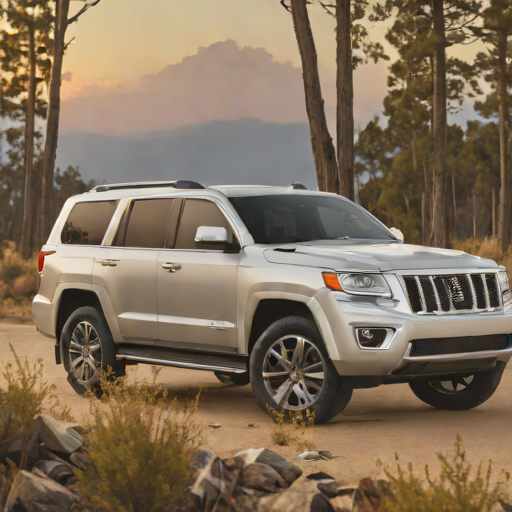

In [47]:
# path of ground truth: /home/ldy/Workspace/THINGS/images_set/test_images
k = 99
image_embeds = emb_img_test[k:k+1]
print("image_embeds", image_embeds.shape)
image = generator.generate(image_embeds)
display(image)

In [48]:
# image_embeds = emb_eeg_test[k:k+1]
# print("image_embeds", image_embeds.shape)
# image = generator.generate(image_embeds)
# display(image)

Generating by eeg informed image embeddings

image_embeds torch.Size([1, 1024])


50it [00:00, 142.90it/s]
100%|██████████| 4/4 [00:00<00:00,  7.52it/s]


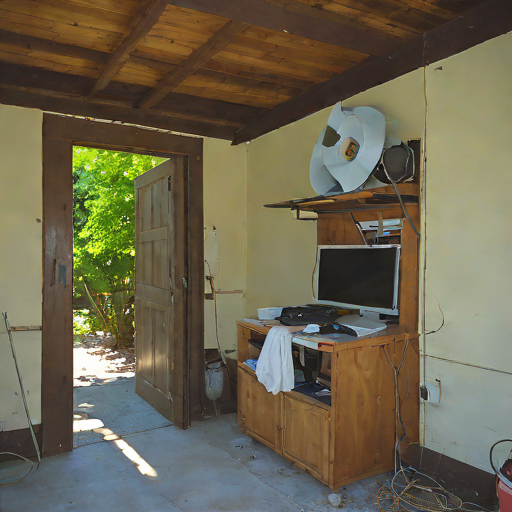

In [49]:
# k = 0
eeg_embeds = emb_eeg_test[k:k+1]
print("image_embeds", eeg_embeds.shape)
h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0)
image = generator.generate(h.to(dtype=torch.float16))
display(image)